# Ejercicio 1 parte 2

Considere los ejemplos vistos en clase, en los que se analizó la
implementación de los modelos: `k-nn`, `regresión lineal`, `regresión logística`. Realice hiperparametrización
y validación cruzada usando (i) `GridSearchCV` y `Pipeline` vs (ii) Manualmente, sin usar GridSearchCV
y Pipeline (Use ciclos FOR, WHILE, etc,. . . ). Verifique que los scores obtenidos en los ítems (i)-(ii)
son los mismos. Los ejercicios son los siguientes:

- Boston Housing: (`LinearRegression`, `KNN`). Utilice la métrica `R2` y `RMSE` durante la evaluación y
selección del modelo. Los resultados deben ser presentados usando el Cuadro 2. Realice un gráfico
en el que muestre en los conjuntos de entrenamiento y test, el precio original y el predicho. El
estudiante que obtenga el mejor score con esta métrica, será premiado con una décima para el
corte.

Los datos deben ser cargados mediante el siguiente par de líneas:

-  import mglearn
-  X, y = mglearn.datasets.load_extended_boston())


## Librerías y paquetes necesarios

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import sklearn
import mglearn
import warnings
import plotly.graph_objects as go
from tabulate import tabulate
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

## Análisis Exploratorio de los datos - EDA

#### Importamos el conjunto de datos

Inicialmente extraemos los datos de la librería `mglearn`, en la cual asignamos a una matriz X nuestras 506 observaciones de 104 variables diferentes y a un vector `Target` nuestros 506 valores que se obtuvieron con base a los `Predictors`.

In [5]:
X, y = mglearn.datasets.load_extended_boston()

In [6]:
# Explorar los datos
print("Shape of X:", X.shape)  # Muestra el número de muestras y características
print("Shape of y:", y.shape)  # Muestra el número de etiquetas


Shape of X: (506, 104)
Shape of y: (506,)


#### Nombres de las variables

Cada uno de las variables involucradas en nuestro análisis corresponen al conjunto de datos de precios promedio de las viviendas en Boston, el cual se desea estimar con base a las mismas y combinaciones entre si.

In [7]:
original_feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

extended_feature_names = original_feature_names.copy()

# Añadir términos cuadráticos y combinaciones (interacciones) de las características originales
for i in range(len(original_feature_names)):
    extended_feature_names.append(f'{original_feature_names[i]}^2')  # Términos cuadráticos
    for j in range(i + 1, len(original_feature_names)):
        extended_feature_names.append(f'{original_feature_names[i]}*{original_feature_names[j]}')  # Interacciones


In [8]:
df_X = pd.DataFrame(X, columns=extended_feature_names)
df_y = pd.DataFrame(y, columns=['MEDV'])

In [9]:
data = pd.concat([df_X, df_y], axis=1)

In [10]:
print(tabulate(data.head(10), headers = 'keys', tablefmt = 'psql'))

+----+-------------+-------+-----------+--------+----------+----------+----------+----------+-----------+-----------+-----------+----------+-----------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----------------+-------------+--------------+----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------+----------+------------+------------+--------------+-------------+------------+-------------+-------------+-------------+-------------+-----------------+-----------+---------------+----------+------------+-----------+------------+------------+------------+------------+----------------+----------+--------------+-----------+-----------+-----------+-----------+------------+-----------+---------------+----------+-------------+----------+----------+----------+-----------+-----------+--------------+----------+------------+----------+-----

In [11]:
print(data.shape)

(506, 105)


In [12]:
summary = data.describe()
print(tabulate(summary, headers = 'keys', tablefmt = 'psql'))

+-------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------------+---------------+---------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+------------+-------------+-------------+--------------+-------------+------------+-------------+-------------+-------------+-------------+-----------------+------------+---------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+----------------+------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+------------+-------------+------------+-

### Gráficas descriptivas
Se realizará un gráfico decsriptivo analizando la distribución de las 103 variables predictoras de tal forma se peuda evidenciar su variabilidad o presencia de datos atípicos. También se analizará la distribución de la varible objetivo.


**Variables Predictoras**

Las distribuciones muestran una variabilidad significativa entre las distintas variables, con algunas que tienen una amplitud mayor (indicando una dispersión considerable) y otras que están más concentradas alrededor de un valor central. Algunas variables tienen una media que parece estar muy cercana a la mediana, lo que sugiere una distribución más simétrica, mientras que otras muestran asimetría, evidenciada por una separación significativa entre estos dos estadísticos.

Al observar la gráfica, se destacan algunas variables, como CRIM, ZN y INDUS, que presentan una mayor dispersión en comparación con otras. La variabilidad en estas variables es amplia, con una distribución que abarca un rango significativo de valores, lo que sugiere que los datos están más dispersos y tienen una mayor diversidad de observaciones.

En contraste, variables como NOX, AGE y TAX exhiben una distribución más concentrada, donde la dispersión es notablemente menor. Estas variables tienden a estar más agrupadas en torno a su mediana, lo que sugiere menos variabilidad en los datos y una menor cantidad de valores extremos.

<Axes: >

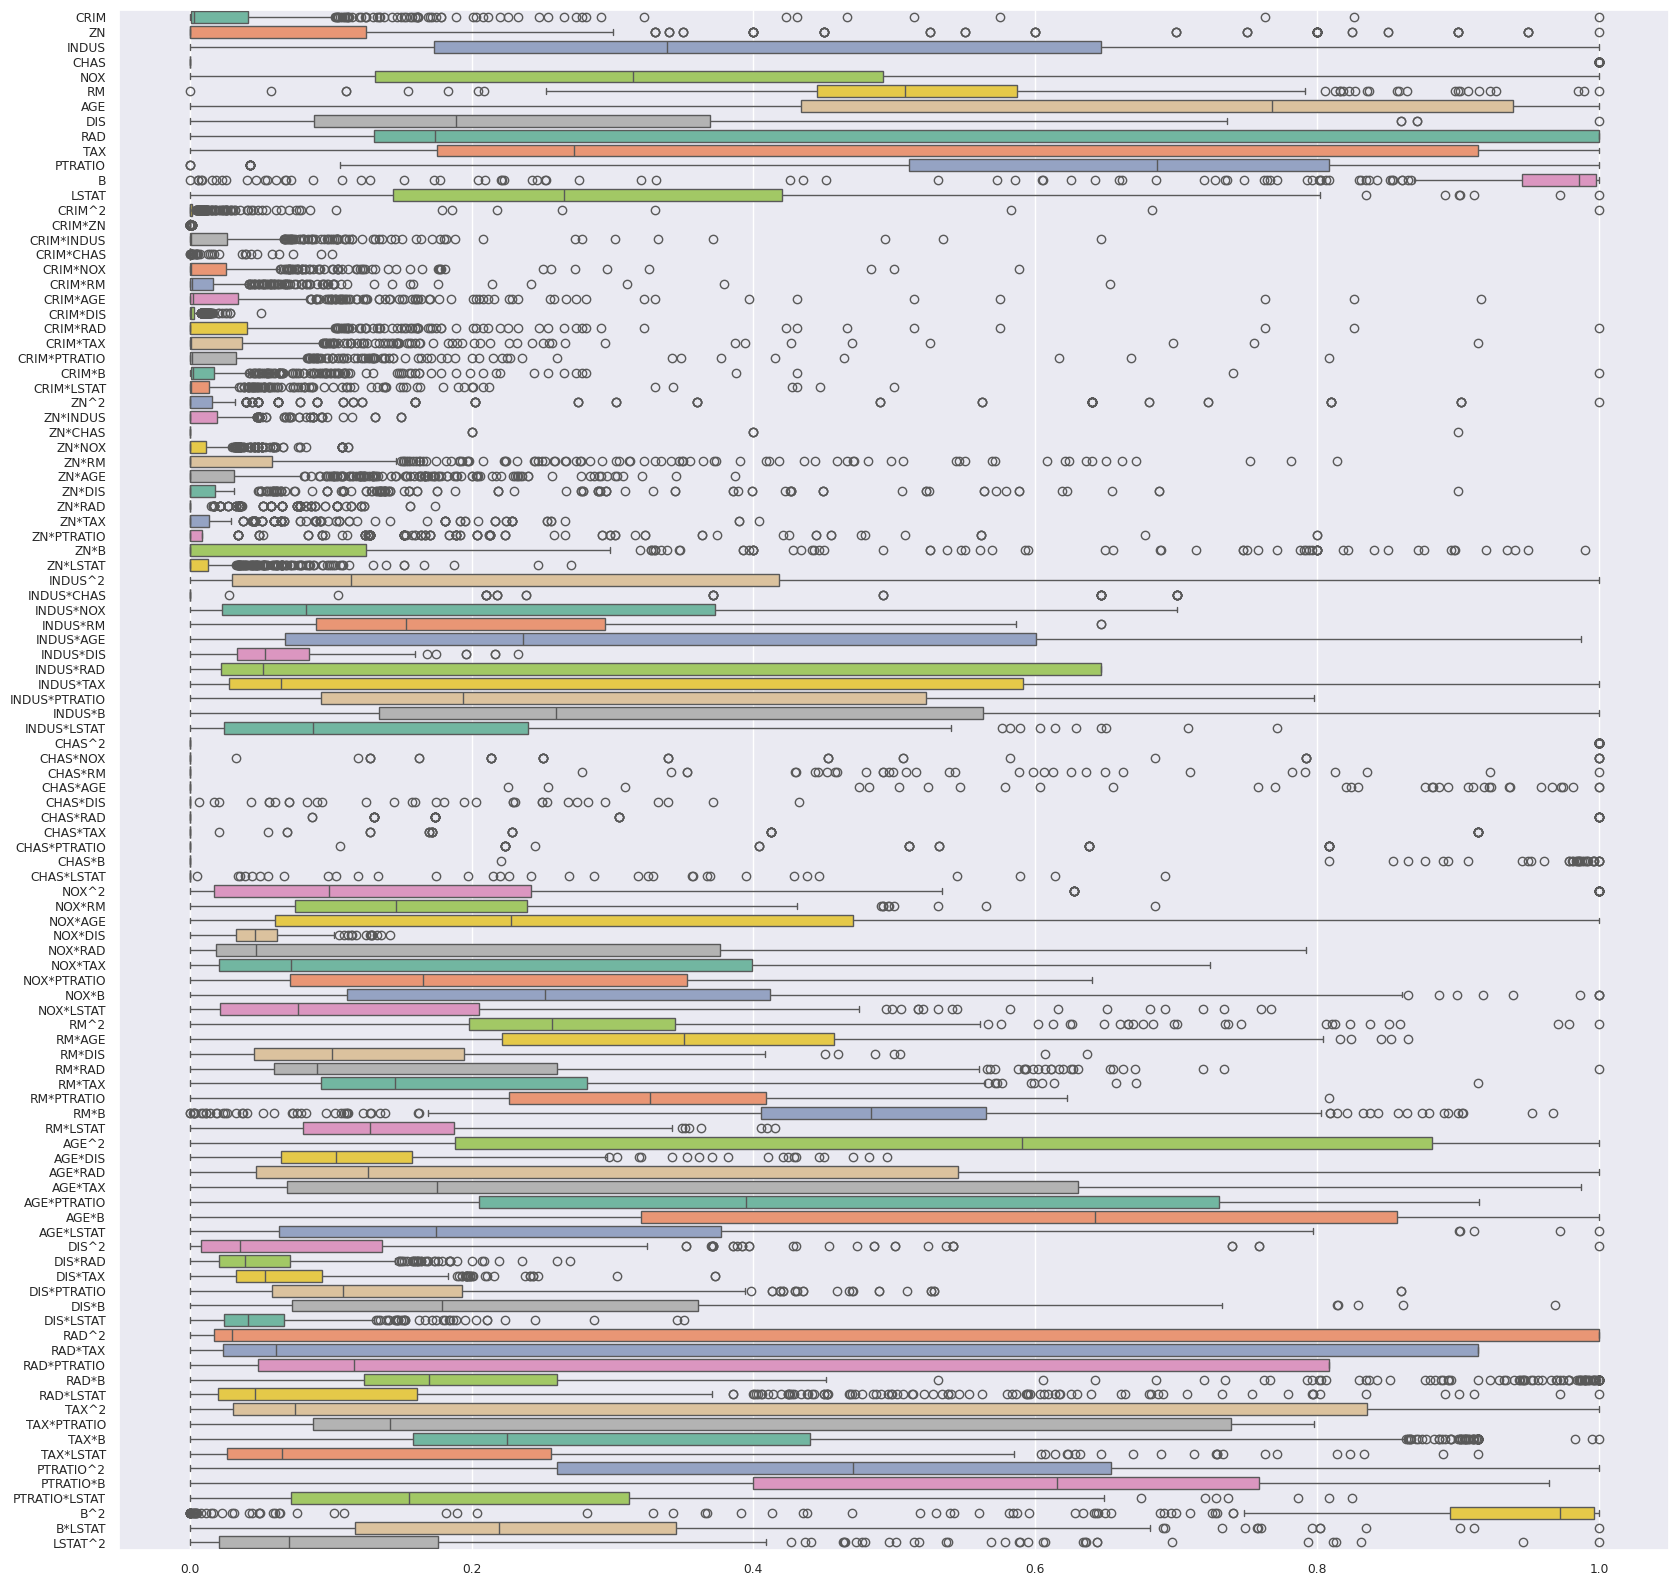

In [13]:
sns.set(font_scale = 0.8)
plt.figure(figsize=(20,20))
sns.boxplot(data=data.drop(['MEDV'], axis=1), orient="h", palette="Set2")

**Variable Objetivo**

En el diagrama de cajas y bigotes, se muestra la distribución del precio promedio de las viviendas en Boston, la variable objetivo (target) del conjunto de datos de Boston.

- `Mediana`: El valor central de la distribución, ubicado en torno a 21. Este valor indica que la mitad de las viviendas tienen un precio promedio menor y la otra mitad tiene un precio promedio mayor.

- `Rango intercuartílico (IQR):` Se observa una concentración importante de los datos entre aproximadamente 17 y 25, lo que refleja que la mayoría de las viviendas están en este rango de precios.

- `Valores atípicos (outliers):` Existen múltiples valores atípicos en el extremo derecho, sobre todo a partir de los 35 hasta alcanzar el máximo posible de 50. Estos outliers representan viviendas que tienen un precio promedio significativamente más alto que el resto.

- `Mínimo y máximo (sin outliers):` El mínimo está cerca de 10 y el máximo (sin contar los outliers) alrededor de 30, lo que nos da una idea del rango en el que se sitúan los precios promedio de las viviendas en Boston.

Text(0.5, 0, 'Precio promedio de las viviendas en Boston')

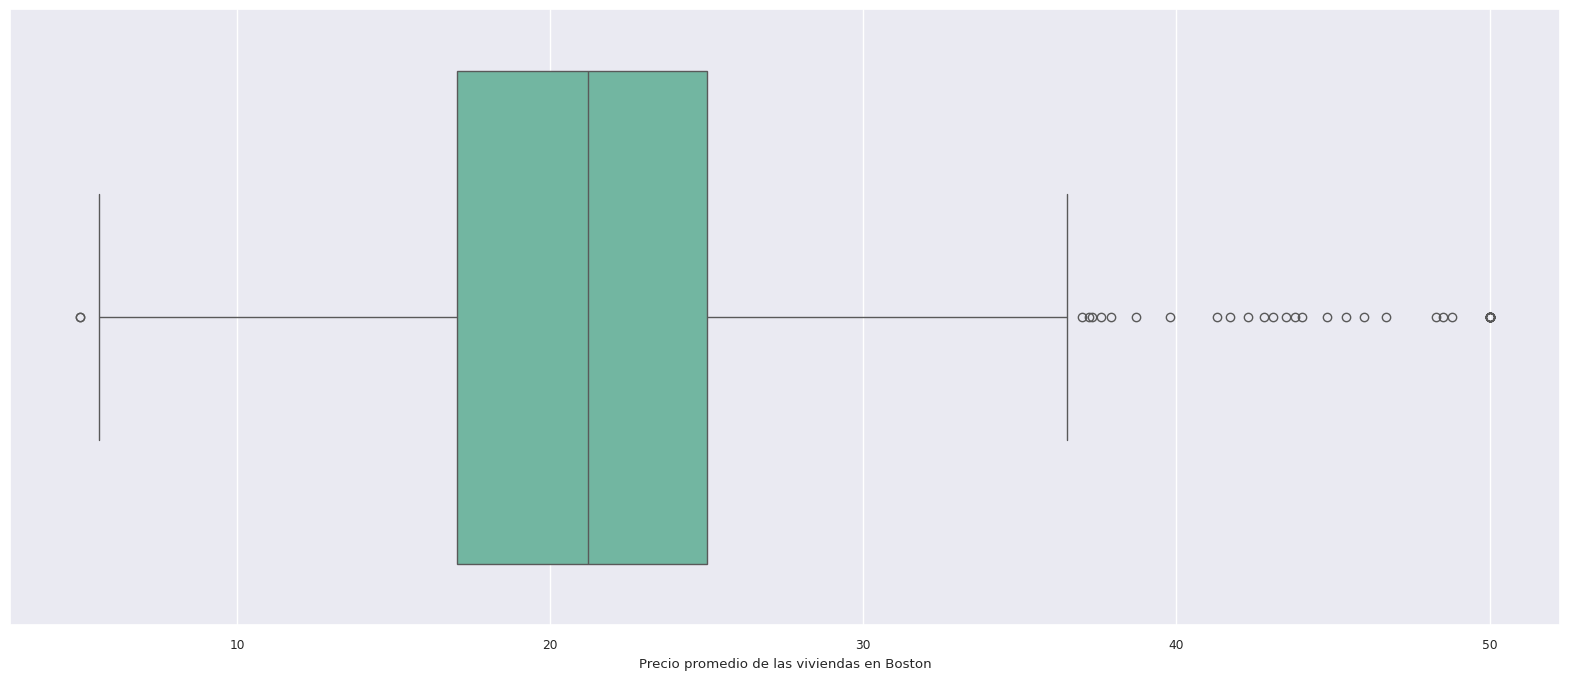

In [14]:
sns.set(font_scale = 0.8)
plt.figure(figsize=(20,8))
sns.boxplot(data=data['MEDV'], orient="h", palette="Set2")
plt.xlabel('Precio promedio de las viviendas en Boston')

### Multicolinealidad

Se realiza una inspección de correlación para observar si existe algún tipo de muticolinealidad entre las variables del conjunto de datos. Posterior a ello se eliminan las variables consideradas como altamente correlacionadas entre si. Dada la distribución de las variables observadas mediante el gráfico de cajas y bigotes, podemos decir que existen correlaciones entre algunas variables basadas en la amplia distribución poseen, es decir, las variables con mayor variabilidad o dispersión y menor presencia de datos atípicos podrían estar más correlacionadas que el resto de las variables.

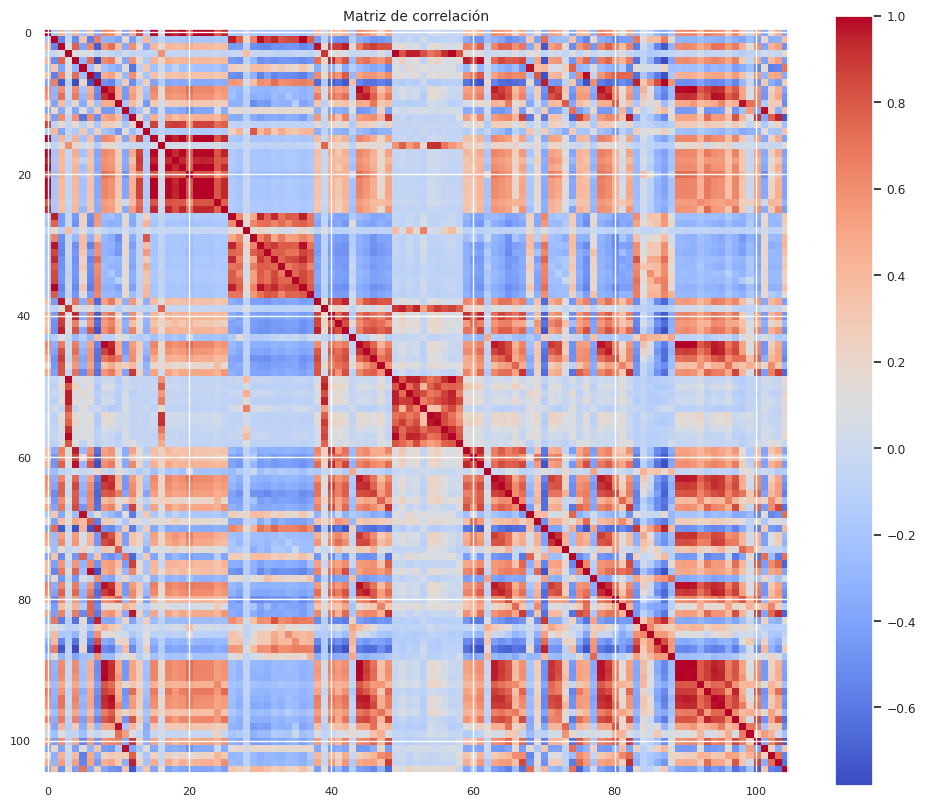

In [15]:
correlation_matrix = data.corr()

# Mostrar la matriz de correlación con texto más pequeño
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Matriz de correlación', fontsize=10)  # Título más pequeño
plt.xticks(fontsize=8)  # Tamaño del texto en el eje x
plt.yticks(fontsize=8)  # Tamaño del texto en el eje y
plt.show()

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
def VIF_calculation(X):
    VIF = pd.DataFrame()
    VIF["variable"] = X.columns
    VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    VIF = VIF.sort_values('VIF', ascending=False).reset_index(drop = True)
    return(VIF)

In [18]:
def delete_multicollinearity(df, target_name, VIF_threshold):
    X = df.drop(target_name, axis=1)  # Aquí usamos target_name para evitar el error
    VIF_mat = VIF_calculation(X)
    n_VIF = VIF_mat["VIF"][0]

    if n_VIF <= VIF_threshold:
        print("There is no multicollinearity!")
    else:
        while n_VIF > VIF_threshold:
            X = X.drop(VIF_mat["variable"][0], axis=1)
            VIF_mat = VIF_calculation(X)
            n_VIF = VIF_mat["VIF"][0]

    display(VIF_mat)
    return X

In [19]:
df_copy = data.copy()  # Asegúrate de definir df_copy
df_copy = delete_multicollinearity(df_copy, "MEDV", 10)

,variable,VIF
0,NOX*DIS,9.734302
1,AGE^2,9.690087
2,CHAS*RAD,9.573889
3,INDUS*DIS,9.231878
4,CRIM*CHAS,8.290902
5,CHAS*NOX,7.310127
6,ZN*NOX,7.122937
7,INDUS^2,6.736253
8,ZN*PTRATIO,6.326790
9,RAD*B,6.247725


Se realiza el proceso de eliminación del conjunto de datos las variables que presentan una alta multicolinealidad, dado que la mayoría de estas son producto de combinaciones aritmeticas entre las variables oríginales del conjunto de datos.

In [20]:
datos = pd.concat([df_copy, df_y], axis=1)

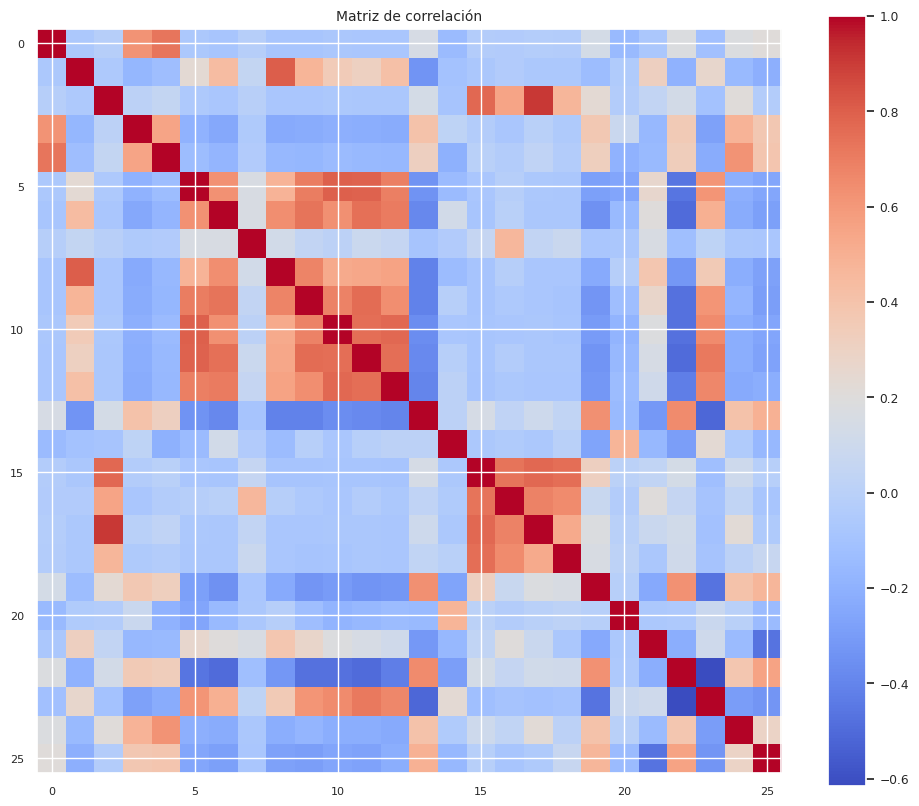

In [21]:
correlation_matrix = df_copy.corr()

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Matriz de correlación', fontsize=10)  # Título más pequeño
plt.xticks(fontsize=8)  # Tamaño del texto en el eje x
plt.yticks(fontsize=8)  # Tamaño del texto en el eje y
plt.show()

In [22]:
datos.columns

Index(['CRIM^2', 'CRIM*ZN', 'CRIM*CHAS', 'CRIM*DIS', 'CRIM*B', 'ZN^2',
       'ZN*INDUS', 'ZN*CHAS', 'ZN*NOX', 'ZN*RAD', 'ZN*TAX', 'ZN*PTRATIO',
       'ZN*LSTAT', 'INDUS^2', 'INDUS*DIS', 'CHAS*NOX', 'CHAS*RM', 'CHAS*RAD',
       'CHAS*LSTAT', 'NOX^2', 'NOX*DIS', 'RM^2', 'AGE^2', 'DIS^2', 'RAD*B',
       'LSTAT^2', 'MEDV'],
      dtype='object')

## Modelo de regresión Lineal Múltiple
### Modelo realizado con funciones de librería

Se realiza el modelo de regresión lineal múltiple con base a las funciones de las librerías de python que no son manuales. Se obtuvo un coeficiente de determinación ($R^2$) cercano al 70%, un puntaje de la métrica de la raíz cuadrada del error cuadrático medio (RMSE) de 4.23, un error absoluto medio (MAE) de 2.56, un puntaje para el error cuadrático medio (MSE) de 22.3 y finalmente el error de porcentaje medio absoluto (MAPE) de 18.31%.

In [23]:
X = datos.drop('MEDV', axis=1)
y = datos['MEDV']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Definimos los parámetros
pipe_lr = Pipeline([('lr', LinearRegression())])
param_grid_lr = {'lr__fit_intercept': [True, False]}

In [26]:
# Definimos los hiperparámetros
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv = 5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lr', LinearRegression())]),
             param_grid={'lr__fit_intercept': [True, False]})

In [27]:
print(f"Mejores hiperparámetros: {grid_lr.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_lr.best_score_}")

Mejores hiperparámetros: {'lr__fit_intercept': True}
Mejor puntuación de validación cruzada: 0.6958551702035134


In [28]:
y_pred_lr = grid_lr.predict(X_test)
best_model = grid_lr.best_estimator_.named_steps

### Métricas del modelo
**Coeficiente de determinación $R^2 $**

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

In [29]:
r2 = r2_score(y_test, y_pred_lr)
coef = best_model['lr'].coef_
intercept = best_model['lr'].intercept_

#### RMSE (Root Mean Squared Error)
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))


### MAE (Mean Absolute Error)

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

In [31]:
mae = mean_absolute_error(y_test, y_pred_lr)


### MSE (Mean Squared Error)
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$


In [32]:
mse = mean_squared_error(y_test, y_pred_lr)


### MAPE (Mean Absolute Percentage Error)
$$MAPE = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

In [33]:
mape = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100


In [34]:
# Crear los datos para la tabla con métricas
table_data_metrics = [
    ["Linear Regression", f"{mape:.2f}", f"{mae:.2f}", f"{rmse:.2f}", f"{mse:.2f}", f"{r2:.2f}"]
]

# Crear los datos para la tabla con coeficientes e intercepto
table_data_coefs = [
    ['Intercepto', intercept]
]

# Añadir los coeficientes con los nombres de las variables a la tabla
feature_names = X_train.columns  # Nombres de las variables del conjunto de entrenamiento
for i, c in enumerate(coef):
    table_data_coefs.append([f'{feature_names[i]}', c])

# Mostrar las tablas usando tabulate
print(tabulate(table_data_metrics, headers=["Modelo", "MAPE", "MAE", "RMSE", "MSE", "R²"], tablefmt="grid"))
print("\nCoeficientes e Intercepto del modelo:")
print(tabulate(table_data_coefs, headers=["Parámetro", "Valor"], tablefmt="psql"))

+-------------------+--------+-------+--------+-------+------+
| Modelo            |   MAPE |   MAE |   RMSE |   MSE |   R² |
+===================+========+=======+========+=======+======+
| Linear Regression |  18.31 |  3.23 |   4.72 |  22.3 |  0.7 |
+-------------------+--------+-------+--------+-------+------+

Coeficientes e Intercepto del modelo:
+-------------+-------------+
| Parámetro   |       Valor |
|-------------+-------------|
| Intercepto  |   21.0028   |
| CRIM^2      |   12.944    |
| CRIM*ZN     | 1080.39     |
| CRIM*CHAS   |  357.005    |
| CRIM*DIS    | -426.316    |
| CRIM*B      |  -19.3523   |
| ZN^2        |    5.91153  |
| ZN*INDUS    |  -13.6239   |
| ZN*CHAS     |   -1.92829  |
| ZN*NOX      |   55.3212   |
| ZN*RAD      |  -11.6295   |
| ZN*TAX      |   -6.00533  |
| ZN*PTRATIO  |   -3.18556  |
| ZN*LSTAT    |  -28.0831   |
| INDUS^2     |    0.339515 |
| INDUS*DIS   |   -4.79366  |
| CHAS*NOX    |   -9.52436  |
| CHAS*RM     |    8.31635  |
| CHAS*RAD    | 

#### Modelo realizado manualmente

Se realiza el modelo de regresión lineal múltiple manualmente con los ciclos requeridos. Se obtuvo un coeficiente de determinación ($R^2$) cercano al 70%, un puntaje de la métrica de la raíz cuadrada del error cuadrático medio (RMSE) de 4.72, un error absoluto medio (MAE) de 2.56, un puntaje para el error cuadrático medio (MSE) de 22.3 y finalmente el error de porcentaje medio absoluto (MAPE) de 18.31%.

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
best_score_lr = -np.inf  # Para almacenar el mejor score (en este caso, R²)
best_params_lr = None    # Para almacenar los mejores hiperparámetros
best_model_lr = None     # Para almacenar el mejor modelo
best_y_pred = None
fit_intercept_options = [True, False]  # Hiperparámetro a probar

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
for fit_intercept in fit_intercept_options:
  pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('lr', LinearRegression(fit_intercept=fit_intercept))
  ])

  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  if r2 > best_score_lr:
    best_score_lr = r2
    best_params_lr = {'fit_intercept': fit_intercept}
    best_model_lr = pipe
    best_y_pred = y_pred_lr



In [38]:
mse = mean_squared_error(y_test, best_y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, best_y_pred)
mape = np.mean(np.abs((y_test - best_y_pred) / y_test)) * 100

# Obtener los coeficientes e intercepto del mejor modelo
coef = best_model_lr.named_steps['lr'].coef_
intercept = best_model_lr.named_steps['lr'].intercept_

# Crear los datos para la tabla con métricas
table_data_metrics = [
    ["Linear Regression", f"{mape:.2f}", f"{mae:.2f}", f"{rmse:.2f}", f"{mse:.2f}", f"{best_score_lr:.2f}"]
]

# Crear los datos para la tabla con coeficientes e intercepto
table_data_coefs = [
    ['Intercepto', intercept]
]

# Añadir los coeficientes con los nombres de las variables a la tabla
feature_names = X_train.columns  # Nombres de las variables del conjunto de entrenamiento
for i, c in enumerate(coef):
    table_data_coefs.append([f'{feature_names[i]}', c])

# Mostrar las tablas usando tabulate
print(tabulate(table_data_metrics, headers=["Modelo", "MAPE", "MAE", "RMSE", "MSE", "R²"], tablefmt="grid"))
print("\nCoeficientes e Intercepto del modelo:")
print(tabulate(table_data_coefs, headers=["Parámetro", "Valor"], tablefmt="psql"))

+-------------------+--------+-------+--------+-------+------+
| Modelo            |   MAPE |   MAE |   RMSE |   MSE |   R² |
+===================+========+=======+========+=======+======+
| Linear Regression |  18.31 |  3.23 |   4.72 |  22.3 |  0.7 |
+-------------------+--------+-------+--------+-------+------+

Coeficientes e Intercepto del modelo:
+-------------+------------+
| Parámetro   |      Valor |
|-------------+------------|
| Intercepto  | 22.7965    |
| CRIM^2      |  0.912764  |
| CRIM*ZN     |  0.2863    |
| CRIM*CHAS   |  3.57308   |
| CRIM*DIS    | -2.16192   |
| CRIM*B      | -1.53143   |
| ZN^2        |  1.05286   |
| ZN*INDUS    | -0.361465  |
| ZN*CHAS     | -0.106697  |
| ZN*NOX      |  1.29635   |
| ZN*RAD      | -0.361505  |
| ZN*TAX      | -0.377784  |
| ZN*PTRATIO  | -0.352676  |
| ZN*LSTAT    | -0.974239  |
| INDUS^2     |  0.0748774 |
| INDUS*DIS   | -0.177149  |
| CHAS*NOX    | -1.39442   |
| CHAS*RM     |  1.30777   |
| CHAS*RAD    | -2.17736   |
| CHAS*L

## Modelo de regresión K-NN
**Modelo con funciones automáticas**

Se realiza el modelo de regresión del K-Vecino más cercano con base a las funciones de las librerías de python que no son manuales. Se determinó que el númro de vecinos óptimos es 2 y se obtuvo un coeficiente de determinación ($R^2$) cercano al 76%, un puntaje de la métrica de la raíz cuadrada del error cuadrático medio (RMSE) de 4.23, un error absoluto medio (MAE) de 2.52, un puntaje para el error cuadrático medio (MSE) de 17.52 y finalmente el error de porcentaje medio absoluto (MAPE) de 13.15%.

In [39]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [40]:
X = datos.drop('MEDV', axis=1)
y = datos['MEDV']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
pipe_knn = Pipeline([
    ('knn', KNeighborsRegressor())  # Modelo KNN
])
param_grid_knn = {'knn__n_neighbors': range(1, 20)}
# Definir la métrica de scoring (en este caso, queremos minimizar el MSE, por eso usamos "neg_mean_squared_error")
scoring = make_scorer(mean_squared_error, greater_is_better=False)


In [43]:
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, scoring=scoring, cv=5)
grid_knn.fit(X_train, y_train)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fdd46ad9900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


GridSearchCV(cv=5, estimator=Pipeline(steps=[('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(1, 20)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))

In [44]:
# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_knn.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_knn.best_score_}")

# Hacer predicciones con el mejor modelo encontrado
y_pred = grid_knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Crear los datos para la tabla con métricas
table_data_metrics = [
    ["K-NN", f"{mape:.2f}", f"{mae:.2f}", f"{rmse:.2f}", f"{mse:.2f}", f"{r2:.2f}"]
]

# Crear los datos para la tabla con los mejores hiperparámetros
best_params_knn = grid_knn.best_params_
table_data_params = [
    ['Modelo', 'Mejores Hiperparámetros'],
    ['K-NN', best_params_knn]
]

# Mostrar la tabla con métricas usando tabulate
print(tabulate(table_data_metrics, headers=["Modelo", "MAPE", "MAE", "RMSE", "MSE", "R²"], tablefmt="grid"))

# Mostrar la tabla con los mejores hiperparámetros
print("\nMejores hiperparámetros:")
print(tabulate(table_data_params, headers="firstrow", tablefmt="grid"))

Mejores hiperparámetros: {'knn__n_neighbors': 2}
Mejor puntuación de validación cruzada: -18.9855549382716
+----------+--------+-------+--------+-------+------+
| Modelo   |   MAPE |   MAE |   RMSE |   MSE |   R² |
+==========+========+=======+========+=======+======+
| K-NN     |  13.15 |  2.52 |   4.23 | 17.92 | 0.76 |
+----------+--------+-------+--------+-------+------+

Mejores hiperparámetros:
+----------+---------------------------+
| Modelo   | Mejores Hiperparámetros   |
+==========+===========================+
| K-NN     | {'knn__n_neighbors': 2}   |
+----------+---------------------------+


### Modelo KNN realizado manualmente

Se realiza el modelo de regresión del K-Vecino más cercano manualmente paso a paso. Se determinó que el númro de vecinos óptimos es 2 y se obtuvo un coeficiente de determinación ($R^2$) cercano al 76%, un puntaje de la métrica de la raíz cuadrada del error cuadrático medio (RMSE) de 4.23, un error absoluto medio (MAE) de 2.52, un puntaje para el error cuadrático medio (MSE) de 17.92 y finalmente el error de porcentaje medio absoluto (MAPE) de 13.15%.

In [45]:
# Inicializar la mejor puntuación
best_score_knn = -np.inf  # Cambiamos a -inf porque estamos maximizando el score negativo (mse negativo)
best_n_neighbors = None   # Para almacenar el mejor valor de n_neighbors

for n_neighbors in range(1, 20):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)

    if mean_score > best_score_knn:
        best_score_knn = mean_score
        best_n_neighbors = n_neighbors

print(f"Mejor número de vecinos: {best_n_neighbors}")
print(f"Mejor puntuación de validación cruzada: {best_score_knn}")

Mejor número de vecinos: 2
Mejor puntuación de validación cruzada: -18.9855549382716


In [46]:
best_knn_model = KNeighborsRegressor(n_neighbors=best_n_neighbors)
best_knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [47]:
y_pred_knn = best_knn_model.predict(X_test)

In [48]:
mse = mean_squared_error(y_test, y_pred_knn)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_knn)
r2 = r2_score(y_test, y_pred_knn)
mape = np.mean(np.abs((y_test - y_pred_knn) / y_test)) * 100

# Crear los datos para la tabla con métricas
table_data_metrics = [
    ["K-NN", f"{mape:.2f}", f"{mae:.2f}", f"{rmse:.2f}", f"{mse:.2f}", f"{r2:.2f}"]
]

# Mostrar los mejores hiperparámetros encontrados manualmente
best_params_knn = {'n_neighbors': best_n_neighbors}

# Crear los datos para la tabla con los mejores hiperparámetros
table_data_params = [
    ['Modelo', 'Mejores Hiperparámetros'],
    ['K-NN', best_params_knn]
]

# Mostrar la tabla con métricas usando tabulate
print(tabulate(table_data_metrics, headers=["Modelo", "MAPE", "MAE", "RMSE", "MSE", "R²"], tablefmt="grid"))

# Mostrar la tabla con los mejores hiperparámetros
print("\nMejores hiperparámetros:")
print(tabulate(table_data_params, headers="firstrow", tablefmt="grid"))

+----------+--------+-------+--------+-------+------+
| Modelo   |   MAPE |   MAE |   RMSE |   MSE |   R² |
+==========+========+=======+========+=======+======+
| K-NN     |  13.15 |  2.52 |   4.23 | 17.92 | 0.76 |
+----------+--------+-------+--------+-------+------+

Mejores hiperparámetros:
+----------+---------------------------+
| Modelo   | Mejores Hiperparámetros   |
+==========+===========================+
| K-NN     | {'n_neighbors': 2}        |
+----------+---------------------------+


### Gráficas conjunto de entrenamiento y prueba
**Modelo de regresión lineal**

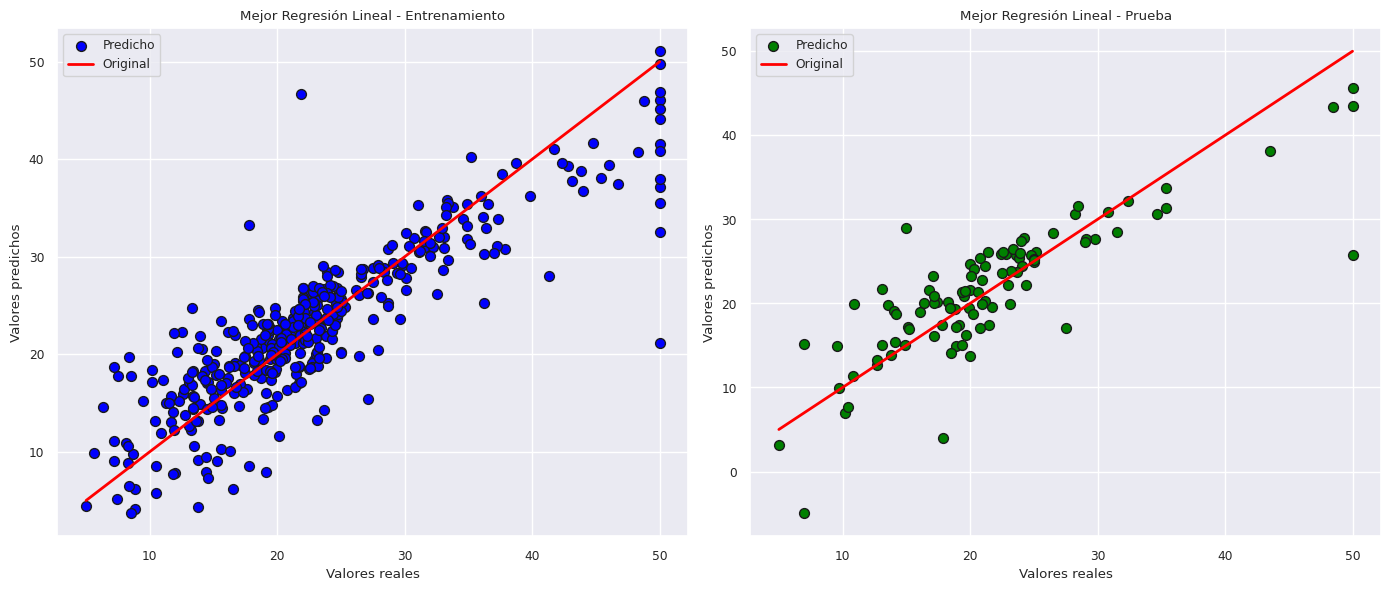

In [49]:
y_train_pred_lr = grid_lr.predict(X_train)
y_test_pred_lr = grid_lr.predict(X_test)

# Función para graficar los resultados
def plot_predictions(y_train, y_train_pred, y_test, y_test_pred, model_name):
    plt.figure(figsize=(14, 6))

    # Graficamos el conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, label="Predicho", color="blue", edgecolor='k', s=50)
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, label="Original")
    plt.title(f"{model_name} - Entrenamiento")
    plt.xlabel("Valores reales")
    plt.ylabel("Valores predichos")
    plt.legend()

    # Graficamos el conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, label="Predicho", color="green", edgecolor='k', s=50)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label="Original")
    plt.title(f"{model_name} - Prueba")
    plt.xlabel("Valores reales")
    plt.ylabel("Valores predichos")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar las predicciones para el mejor modelo de Regresión Lineal
plot_predictions(y_train, y_train_pred_lr, y_test, y_test_pred_lr, "Mejor Regresión Lineal")

**Modelo de regresión KNN**

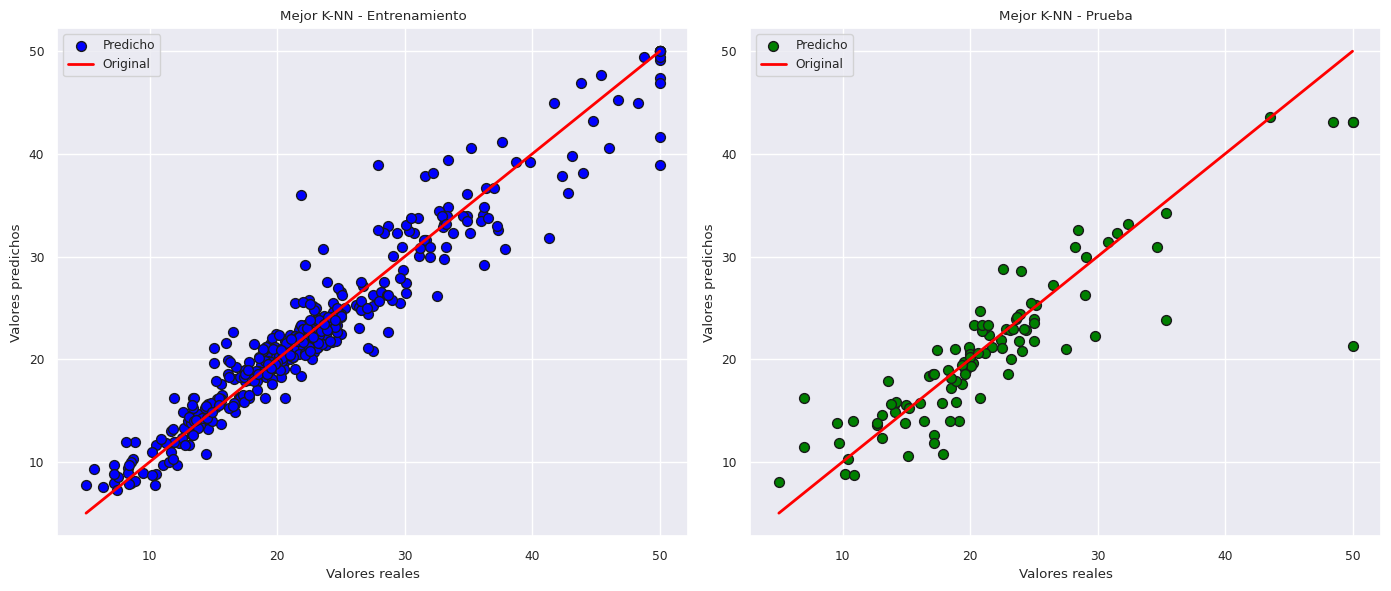

In [50]:
y_train_pred_knn = best_knn_model.predict(X_train)
y_test_pred_knn = best_knn_model.predict(X_test)

def plot_predictions(y_train, y_train_pred, y_test, y_test_pred, model_name):
    plt.figure(figsize=(14, 6))

    # Graficamos el conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, label="Predicho", color="blue", edgecolor='k', s=50)
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, label="Original")
    plt.title(f"{model_name} - Entrenamiento")
    plt.xlabel("Valores reales")
    plt.ylabel("Valores predichos")
    plt.legend()

    # Graficamos el conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, label="Predicho", color="green", edgecolor='k', s=50)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label="Original")
    plt.title(f"{model_name} - Prueba")
    plt.xlabel("Valores reales")
    plt.ylabel("Valores predichos")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar las predicciones para el mejor modelo de K-NN
plot_predictions(y_train, y_train_pred_knn, y_test, y_test_pred_knn, "Mejor K-NN")

## Conclusiones

Para el modelo K-NN, el valor de R² es 0.7556, mientras que para la Regresión Lineal es 0.6960. Un valor más cercano a 1 indica un mejor ajuste, lo que sugiere que K-NN tiene un ajuste ligeramente mejor que la Regresión Lineal en este caso.

En la métrica RMSE para K-NN, el RMSE es 4.23, mientras que para la Regresión Lineal es 4.72. El modelo K-NN tiene un error más bajo, lo que significa que las predicciones tienden a estar más cerca de los valores reales en comparación con la Regresión Lineal.

De acuerdo con las métricas R² y RMSE, el modelo K-NN parece ser la mejor opción en este caso, ya que tiene un mejor ajuste a los datos (mayor R²) y un error de predicción más bajo (RMSE más bajo).

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred):
    # Calculamos las métricas para las predicciones dadas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R²': r2}


metrics_knn = calculate_metrics(y_test, y_pred_knn)
metrics_lr = calculate_metrics(y_test, y_pred_lr)

df_metrics = pd.DataFrame({
    'Modelo': ['K-NN', 'Linear Regression'],
    'MAPE': [metrics_knn['MAPE'], metrics_lr['MAPE']],
    'MAE': [metrics_knn['MAE'], metrics_lr['MAE']],
    'RMSE': [metrics_knn['RMSE'], metrics_lr['RMSE']],
    'MSE': [metrics_knn['MSE'], metrics_lr['MSE']],
    'R²': [metrics_knn['R²'], metrics_lr['R²']]
})

df_metrics

,Modelo,MAPE,MAE,RMSE,MSE,R²
0,K-NN,13.152268,2.521078,4.233593,17.923309,0.755593
1,Linear Regression,18.306898,3.226430,4.721888,22.296224,0.695962
